# 4. DQN
DQN的关键：value approximation，从离散式的表格进化到连续的值函数近似。使用非线性的神经网络拟合值函数即Deep Q-Learning (DQN)。为了确保训练稳定性，分别训练main network和target network。

## 4.1 DQN基础版

In [ ]:
import random
import gymnasium as gym
import numpy as np
import collections
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import rl_utils

In [8]:
class ReplayBuffer:
    ''' 经验回放池 '''
    def __init__(self, capacity):   # 新建一个buffer, 定义回放池的容量
        self.buffer = collections.deque(maxlen=capacity)  # 定义一个队列, 先进先出

    def add(self, state, action, reward, next_state, done):  # 将数据加入buffer
        self.buffer.append((state, action, reward, next_state, done))   # 元组的格式

    def sample(self, batch_size):  # 从buffer中采样数据, 数量为batch_size
        transitions = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = zip(*transitions) # 解包
        return np.array(state), action, reward, np.array(next_state), done

    def size(self):  # 目前buffer中数据的数量
        return len(self.buffer)

In [15]:
class Qnet(nn.Module):
    ''' 只有一层隐藏层的Q网络 '''
    def __init__(self, state_dim, hidden_dim, action_dim):  
        super(Qnet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)   # 输入状态维度 到隐藏层
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim)  # 隐藏层到动作维度

    def forward(self, x):
        x = F.relu(self.fc1(x))  # 隐藏层使用ReLU激活函数
        return self.fc2(x)

In [ ]:
class DQN:
    ''' DQN算法 '''
    def __init__(self, state_dim, hidden_dim, action_dim, learning_rate, gamma,
                 epsilon, target_update, device):
        self.action_dim = action_dim
        # 使用Qnet类创建Q网络 main network
        self.q_net = Qnet(state_dim, hidden_dim,
                          self.action_dim).to(device)
        # 目标网络 target network
        self.target_q_net = Qnet(state_dim, hidden_dim,
                                 self.action_dim).to(device)
        # 使用Adam优化器
        self.optimizer = torch.optim.Adam(self.q_net.parameters(),
                                          lr=learning_rate)
        self.gamma = gamma  # 折扣因子
        self.epsilon = epsilon  # epsilon-贪婪策略
        self.target_update = target_update  # 目标网络更新频率
        self.count = 0  # 计数器,记录更新次数
        self.device = device

    def take_action(self, state):  # epsilon-贪婪策略采取动作
        if np.random.random() < self.epsilon:   # 以小于epsilon的概率随机抽样
            action = np.random.randint(self.action_dim)    # 从action_dim随机抽一个整数
        else:
            # torch.tensor(): 新建一个张量, dtype = torch.float: 浮点类型
            # state是形状为 (state_dim,)的一维数组, 用[state]则变成[[...]], 增加了一个维度
            # 维度变成 (1, state_dim), 包装成batch_size = 1的batch
            state = torch.tensor([state], dtype=torch.float).to(self.device)

            # 将 (1, state_dim) 的状态输入Q网络，输出每个动作的Q值，得到(1, action_dim) 的张量
            # .argmax(): 沿着最后一个维度（动作）寻找最大值的索引。输出一个形状为 () 的零维张量，只包含一个数值（即动作的索引）
            # .item(): 将这个零维张量中的数值提取出来，转换成标准的Python整数
            action = self.q_net(state).argmax().item()
        return action

    def update(self, transition_dict):  # transition_dict: 一个字典，包含一组的经验数据
        # 将一批（batch）状态数据从数组转换为张量
        states = torch.tensor(transition_dict['states'], dtype=torch.float).to(self.device)
        # .view(-1, 1): 将一维张量重塑为二维
        actions = torch.tensor(transition_dict['actions']).view(-1, 1).to(self.device)
        rewards = torch.tensor(transition_dict['rewards'], dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'], dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'], dtype=torch.float).view(-1, 1).to(self.device)

        # self.q_net(states): 形状为(batch_size, action_dim), 网络输出的是每个动作的价值（相当于一张表）
        # actions: (batch_size, 1), buffer中实际执行动作的索引
        # q_values: 按照动作索引, 输出实际执行动作对应的价值
        q_values = self.q_net(states).gather(1, actions)    # 相当于预测值

        # max(1): 沿着action_dim寻找最大值, 返回一个元组 (values, indices)
        # 只关心最大值本身, 所以取第0个维度
        # 此时张量形状为(B, ), 需用view()转换为(B,1)
        max_next_q_values = self.target_q_net(next_states).max(1)[0].view(
            -1, 1)  # 直接在目标网络上取动作最大值
        q_targets = rewards + self.gamma * max_next_q_values * (1 - dones)  # TD误差目标
        dqn_loss = torch.mean(F.mse_loss(q_values, q_targets))  # 均方误差损失函数
        self.optimizer.zero_grad()  # PyTorch中默认梯度会累积,这里需要显式将梯度置为0
        dqn_loss.backward()  # 反向传播更新参数
        self.optimizer.step()

        if self.count % self.target_update == 0:
            self.target_q_net.load_state_dict(
                self.q_net.state_dict())  # 更新目标网络
        self.count += 1

In [13]:
learning_rate = 1e-3
num_episodes = 500
hidden_dim = 128
gamma = 0.98
epsilon = 0.01
target_update = 10
buffer_size = 10000
minimal_size = 500
batch_size = 64
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

env_name = 'CartPole-v1'
env = gym.make(env_name)

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

# 从环境中获取状态和动作维度
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

# 实例化ReplayBuffer和DQN Agent
replay_buffer = ReplayBuffer(buffer_size)
agent = DQN(state_dim, hidden_dim, action_dim, learning_rate, gamma, epsilon,
            target_update, device)

# 开始训练
return_list = []
for i in range(10):
    # 创建一个进度条，每个进度条记录1/10的episode
    with tqdm(total=int(num_episodes / 10), desc='Iteration %d' % i) as pbar:
        # 在这个进度条内部，执行 1/10 的回合数
        for i_episode in range(int(num_episodes / 10)):
            episode_return = 0
            state, info = env.reset(seed=0) # 保证可复现
            
            done = False
            while not done:
                action = agent.take_action(state)   # 执行动作
                next_state, reward, terminated, truncated, info = env.step(action)
                done = terminated or truncated

                replay_buffer.add(state, action, reward, next_state, done)  # 加入经验回放池
                state = next_state  # 更新状态
                episode_return += reward    # 更新return

                if replay_buffer.size() > minimal_size:
                    b_s, b_a, b_r, b_ns, b_d = replay_buffer.sample(batch_size)
                    transition_dict = {
                        'states': b_s,
                        'actions': b_a,
                        'rewards': b_r,
                        'next_states': b_ns,
                        'dones': b_d
                    }
                    agent.update(transition_dict)   # 使用经验来更新函数
            
            return_list.append(episode_return)  # 这一轮的return
            
            # 更新进度条信息
            if (i_episode + 1) % 10 == 0:
                pbar.set_postfix({
                    'episode':
                    '%d' % (num_episodes / 10 * i + i_episode + 1),
                    'return':
                    '%.3f' % np.mean(return_list[-10:])
                })
            pbar.update(1)

env.close()

Iteration 9: 100%|██████████| 50/50 [00:06<00:00,  7.60it/s, episode=500, return=331.700]


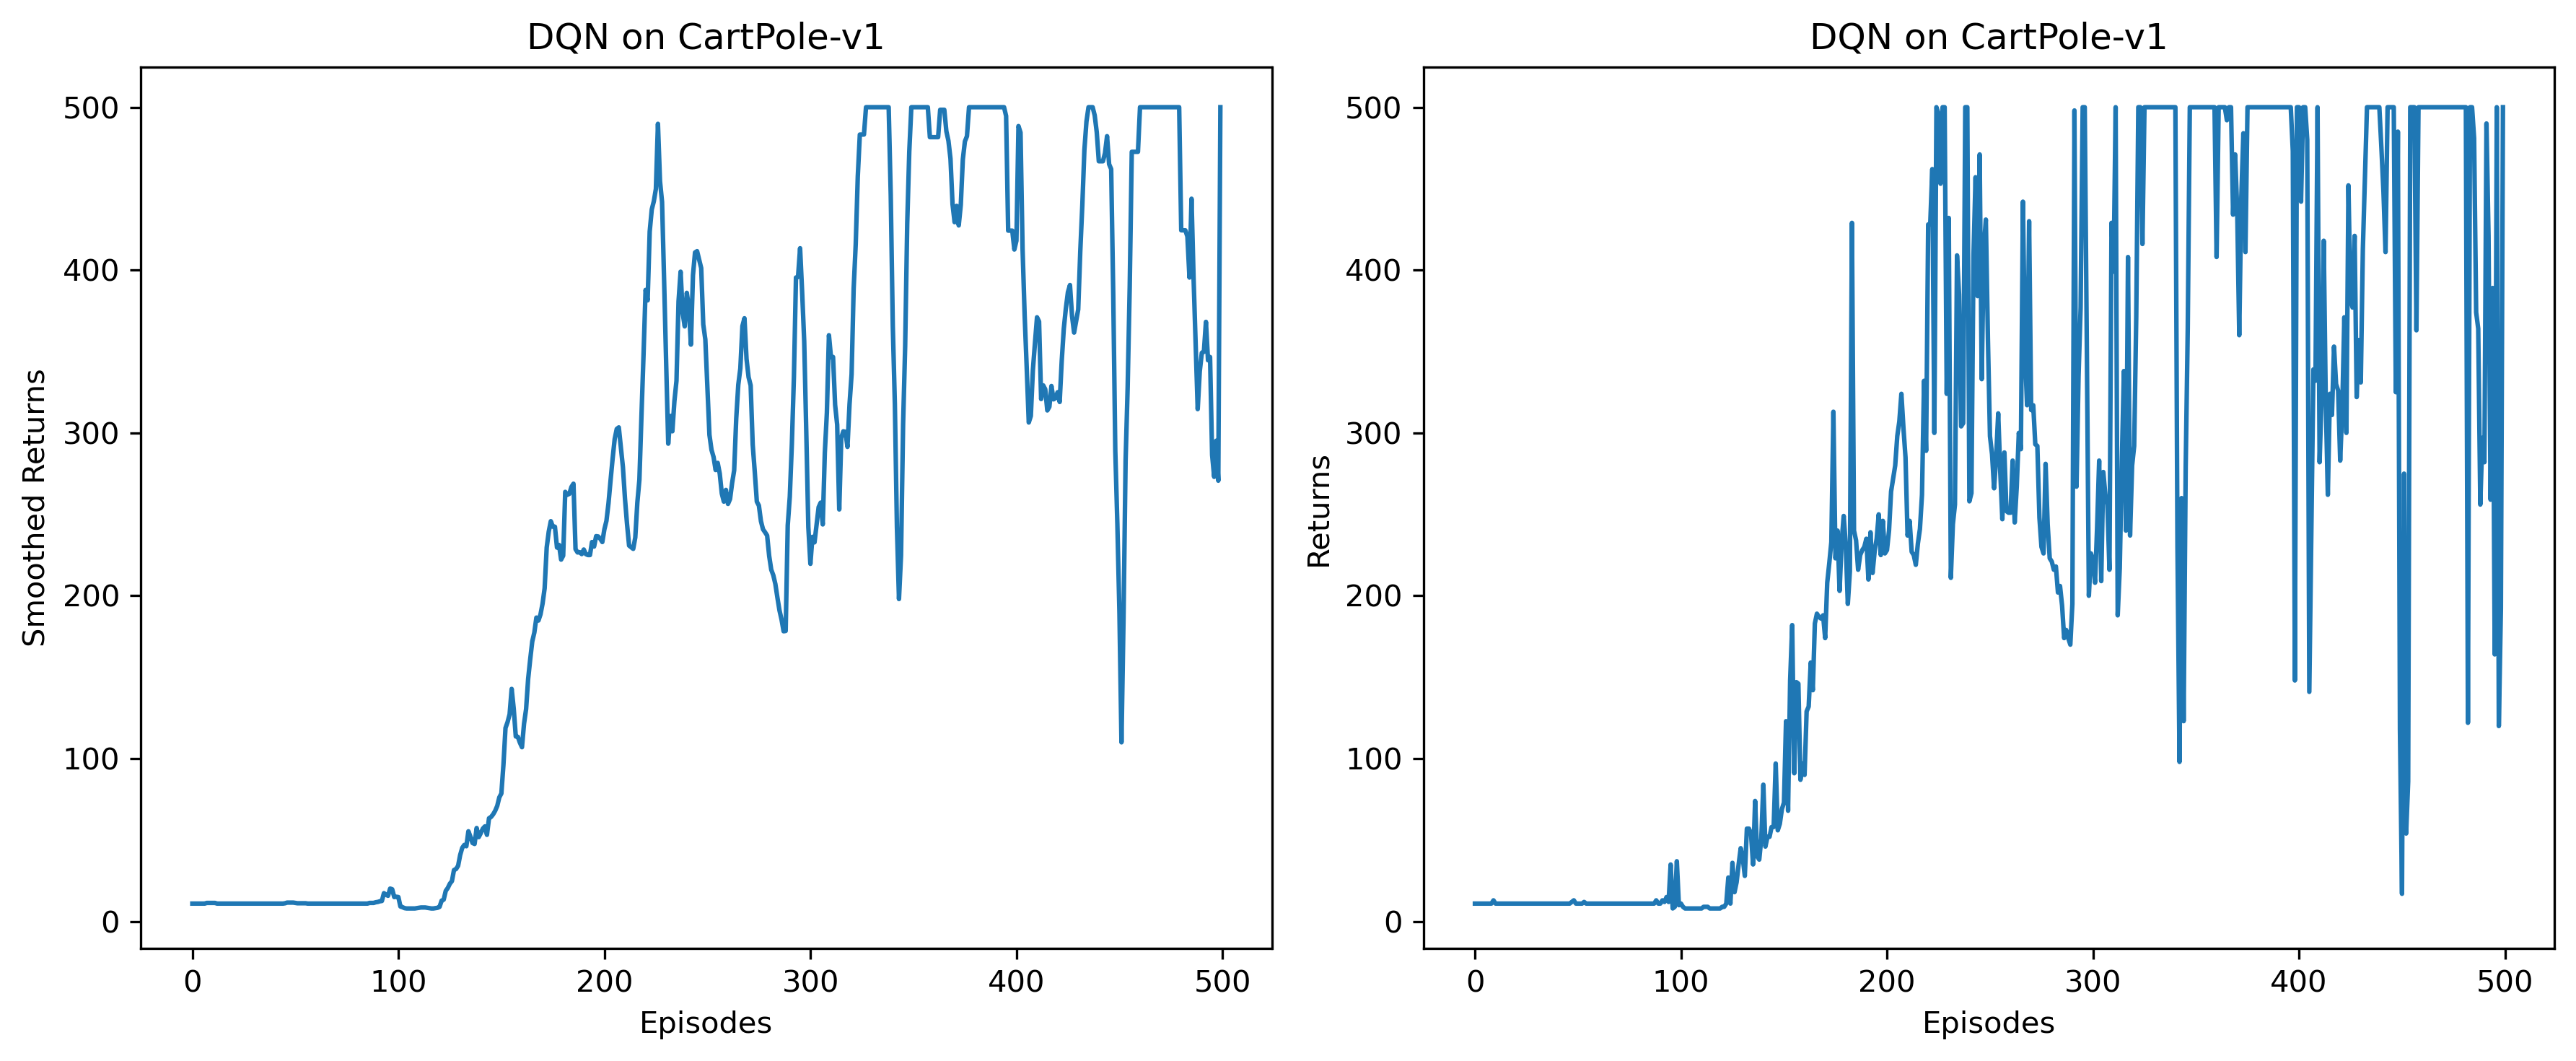

In [14]:
episodes_list = list(range(len(return_list)))
mv_return = rl_utils.moving_average(return_list, 5)

plt.figure(figsize=(12, 5), dpi = 300)
    
plt.subplot(1, 2, 1)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Smoothed Returns')
plt.title('DQN on {}'.format(env_name))

plt.subplot(1, 2, 2)
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('DQN on {}'.format(env_name))
    
plt.tight_layout()
plt.show()

## 4.2 DQN改进版
在 DQN 之后，学术界涌现出了非常多的改进算法。本章将介绍其中两个非常著名的算法：Double DQN 和 Dueling DQN。

### 4.2.1 Double DQN

In [24]:
class Qnet(nn.Module):
    ''' 只有一层隐藏层的神经网络Qnet '''
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(Qnet, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)

class ReplayBuffer:
    ''' 经验回放池 '''
    def __init__(self, capacity):
        self.buffer = collections.deque(maxlen=capacity)

    def add(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        transitions = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*transitions)
        return np.array(states), actions, rewards, np.array(next_states), dones

    def size(self):
        return len(self.buffer)

def moving_average(a, window_size):
    ''' rl_utils.moving_average 的标准实现 '''
    cumulative_sum = np.cumsum(np.insert(a, 0, 0))
    middle = (cumulative_sum[window_size:] - cumulative_sum[:-window_size]) / window_size
    r = np.arange(1, window_size - 1, 2)
    begin = np.cumsum(a[:window_size - 1])[::2] / r
    end = (np.cumsum(a[:-window_size:-1])[::2] / r)[::-1]
    return np.concatenate((begin, middle, end))

class DQN:
    ''' DQN算法,包括Double DQN '''
    def __init__(self, state_dim, hidden_dim, action_dim, learning_rate, gamma,
                 epsilon, target_update, device, dqn_type='VanillaDQN'):
        self.action_dim = action_dim
        self.q_net = Qnet(state_dim, hidden_dim, self.action_dim).to(device)
        self.target_q_net = Qnet(state_dim, hidden_dim, self.action_dim).to(device)
        self.optimizer = torch.optim.Adam(self.q_net.parameters(), lr=learning_rate)
        self.gamma = gamma
        self.epsilon = epsilon
        self.target_update = target_update
        self.count = 0
        self.dqn_type = dqn_type
        self.device = device

    def take_action(self, state):   # 同样是epsilon-greedy策略
        if np.random.random() < self.epsilon:
            action = np.random.randint(self.action_dim)
        else:
            state = torch.tensor([state], dtype=torch.float).to(self.device)
            action = self.q_net(state).argmax().item()
        return action

    def max_q_value(self, state):
        with torch.no_grad():
            state = torch.tensor([state], dtype=torch.float).to(self.device)
            return self.q_net(state).max().item()

    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'], dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions']).view(-1, 1).to(self.device)
        rewards = torch.tensor(transition_dict['rewards'], dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'], dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'], dtype=torch.float).view(-1, 1).to(self.device)

        q_values = self.q_net(states).gather(1, actions)

        # 如果是DoubleDQN的情况
        if self.dqn_type == 'DoubleDQN':
            # 在main network上选择最好的动作 输出动作索引dim=1
            max_action = self.q_net(next_states).max(1)[1].view(-1, 1)
            # 在target network上计算最好动作的价值
            max_next_q_values = self.target_q_net(next_states).gather(1, max_action)
        else:
            # 否则直接在target network完成选动作+评估
            max_next_q_values = self.target_q_net(next_states).max(1)[0].view(-1, 1)
        # td target
        q_targets = rewards + self.gamma * max_next_q_values * (1 - dones)
        dqn_loss = torch.mean(F.mse_loss(q_values, q_targets))
        self.optimizer.zero_grad()
        dqn_loss.backward()
        self.optimizer.step()
        if self.count % self.target_update == 0:
            self.target_q_net.load_state_dict(self.q_net.state_dict())
        self.count += 1


def train_DQN(agent, env, num_episodes, replay_buffer, minimal_size, batch_size):
    return_list = []
    max_q_value_list = []
    max_q_value = 0

    for i in range(10):
        with tqdm(total=int(num_episodes / 10), desc=f'Iteration {i}') as pbar:
            for i_episode in range(int(num_episodes / 10)):
                episode_return = 0
                
                state, info = env.reset()
                
                done = False
                while not done:
                    action = agent.take_action(state)
                    
                    max_q_value = agent.max_q_value(state) * 0.005 + max_q_value * 0.995
                    max_q_value_list.append(max_q_value)
                    
                    action_continuous = dis_to_con(action, env, agent.action_dim)
                    
                    next_state, reward, terminated, truncated, info = env.step([action_continuous])
                    done = terminated or truncated

                    replay_buffer.add(state, action, reward, next_state, done)
                    state = next_state
                    episode_return += reward

                    if replay_buffer.size() > minimal_size:
                        b_s, b_a, b_r, b_ns, b_d = replay_buffer.sample(batch_size)
                        transition_dict = {'states': b_s, 'actions': b_a, 'next_states': b_ns, 'rewards': b_r, 'dones': b_d}
                        agent.update(transition_dict)

                return_list.append(episode_return)
                
                if (i_episode + 1) % 10 == 0:
                    pbar.set_postfix({'episode': f'{num_episodes / 10 * i + i_episode + 1}',
                                      'return': f'{np.mean(return_list[-10:]):.3f}'})
                
                pbar.update(1)
                
    return return_list, max_q_value_list

def dis_to_con(discrete_action, env, action_dim):
    action_lowbound = env.action_space.low[0]
    action_upbound = env.action_space.high[0]
    return action_lowbound + (discrete_action / (action_dim - 1)) * (action_upbound - action_lowbound)

Iteration 9: 100%|██████████| 20/20 [00:01<00:00, 13.83it/s, episode=200.0, return=-303.462]


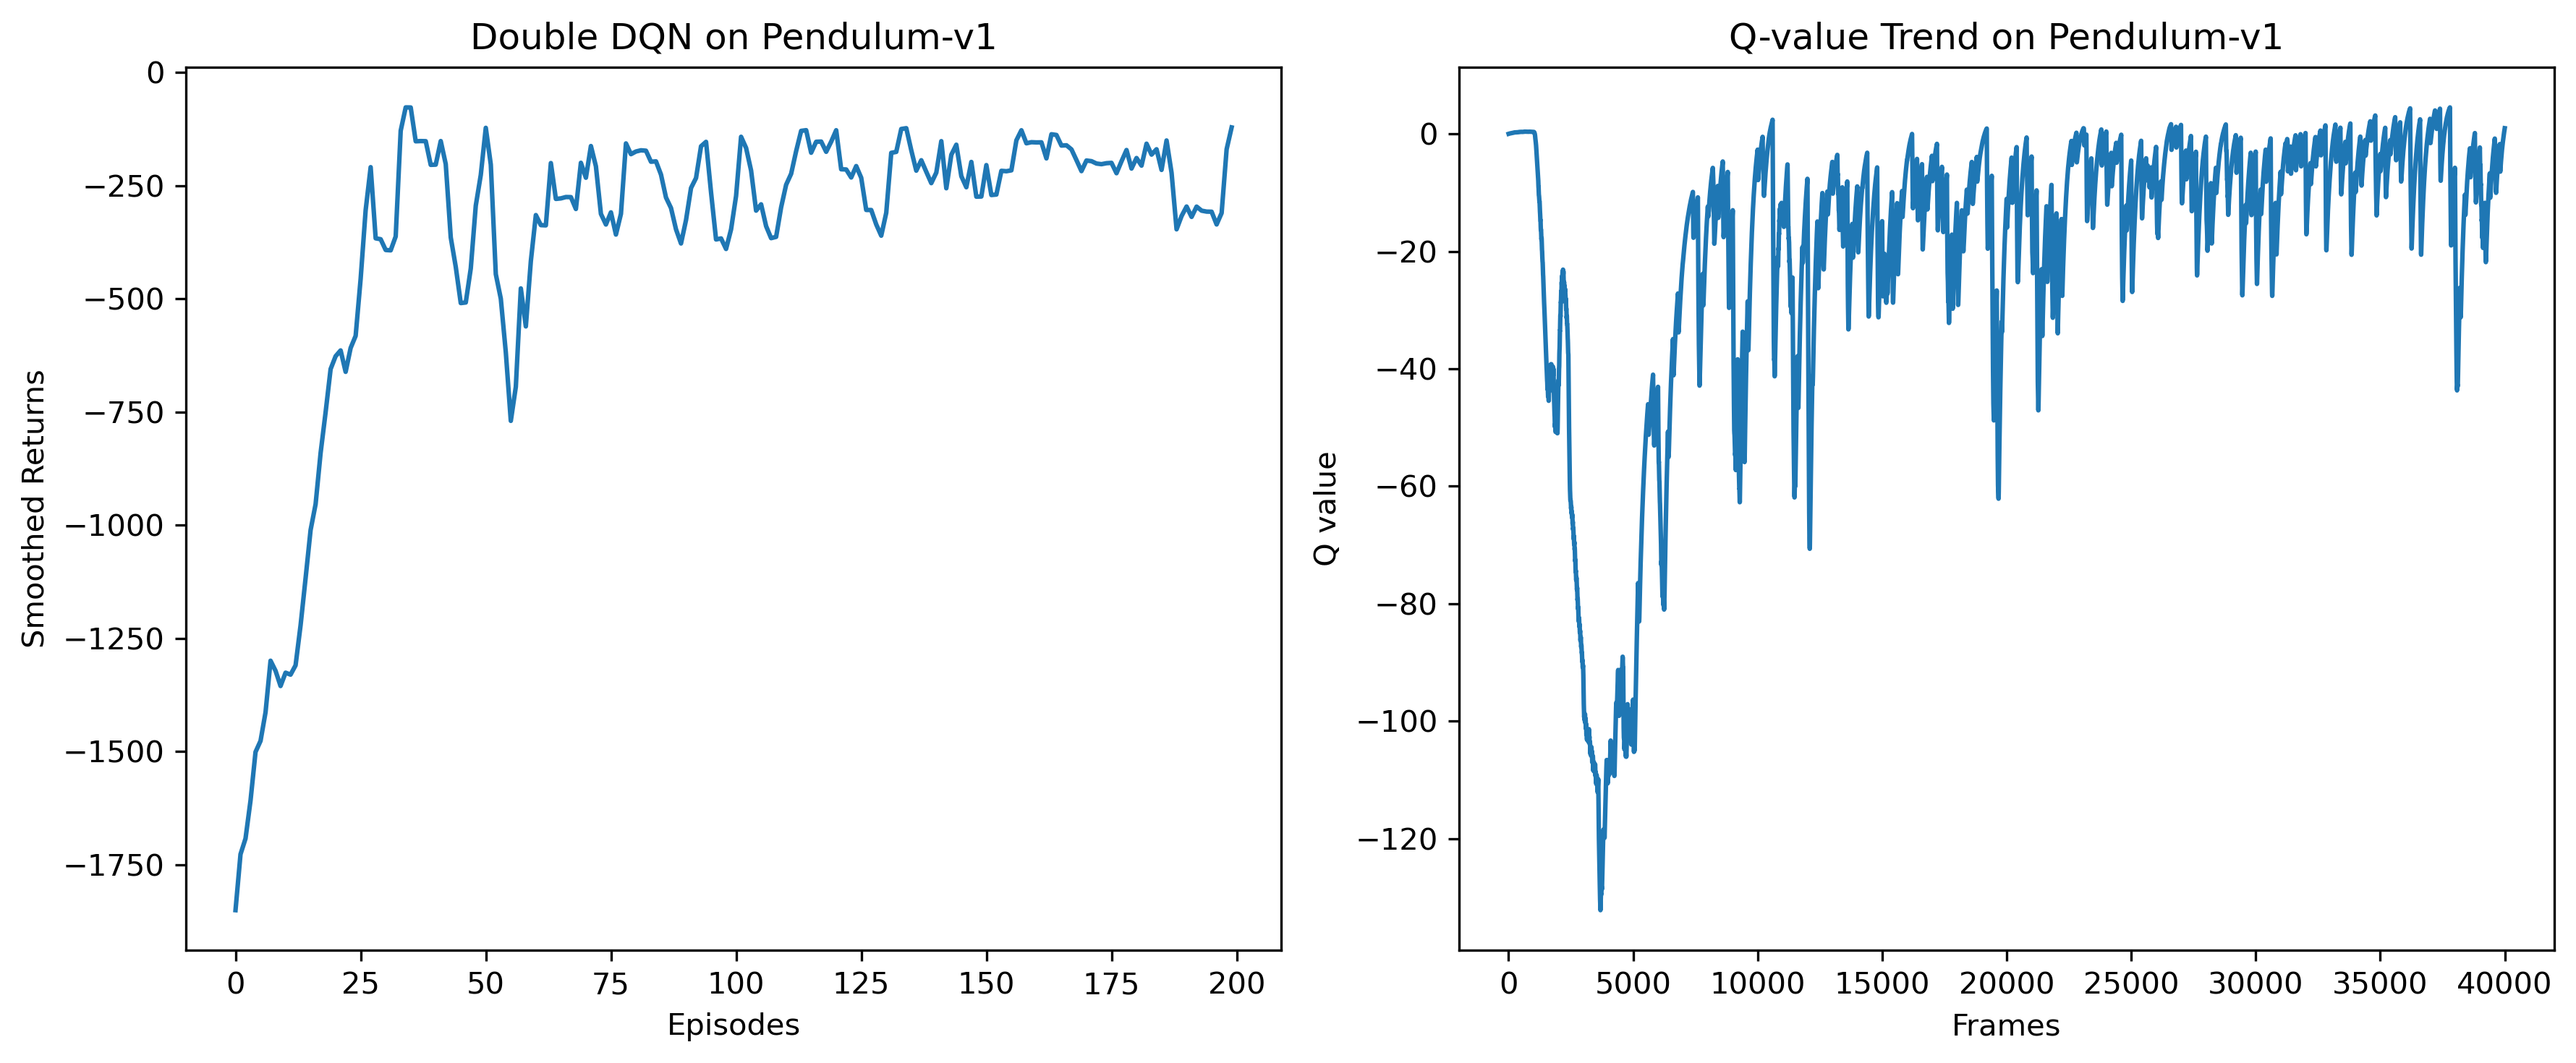

In [25]:
# 训练Double DQN
lr = 1e-2
num_episodes = 200
hidden_dim = 128
gamma = 0.98
epsilon = 0.01
target_update = 50
buffer_size = 5000
minimal_size = 1000
batch_size = 64
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

env_name = 'Pendulum-v1'
env = gym.make(env_name)
state_dim = env.observation_space.shape[0]
action_dim = 11  # 将连续动作分成11个离散动作

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
env.reset(seed=0)

# 实例化buffer和agent
replay_buffer = ReplayBuffer(buffer_size)
agent = DQN(state_dim, hidden_dim, action_dim, lr, gamma, epsilon,
                target_update, device, dqn_type='DoubleDQN')

# 训练agent
return_list, max_q_value_list = train_DQN(agent, env, num_episodes,
                                          replay_buffer, minimal_size,
                                          batch_size)
env.close()

# 画图
episodes_list = list(range(len(return_list)))
mv_return = moving_average(return_list, 5)
    
plt.figure(figsize=(12, 5), dpi = 300)
    
plt.subplot(1, 2, 1)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Smoothed Returns')
plt.title(f'Double DQN on {env_name}')

plt.subplot(1, 2, 2)
frames_list = list(range(len(max_q_value_list)))
plt.plot(frames_list, max_q_value_list)
plt.xlabel('Frames')
plt.ylabel('Q value')
plt.title(f'Q-value Trend on {env_name}')
    
plt.tight_layout()
plt.show()

### 4.2.2 Dueling DQN

In [ ]:
class VAnet(nn.Module):
    ''' Dueling DQN 网络结构 '''
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(VAnet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)  # 共享网络部分
        self.fc_A = torch.nn.Linear(hidden_dim, action_dim) # 优势函数 A
        self.fc_V = torch.nn.Linear(hidden_dim, 1)          # 状态价值函数 V

    def forward(self, x):
        # 分别计算 A 和 V 
        x_relu = F.relu(self.fc1(x))
        A = self.fc_A(x_relu)
        V = self.fc_V(x_relu)
        # 直接相加会导致V和A无法被唯一确定（不可识别性）
        # 因此对优势函数A进行中心化（减去均值）
        Q = V + A - A.mean(1).view(-1, 1)
        return Q

class DuelingDQN:
    ''' Dueling DQN '''
    def __init__(self, state_dim, hidden_dim, action_dim, learning_rate, gamma,
                 epsilon, target_update, device):
        self.action_dim = action_dim
        self.q_net = VAnet(state_dim, hidden_dim, self.action_dim).to(device)
        self.target_q_net = VAnet(state_dim, hidden_dim, self.action_dim).to(device)

        self.optimizer = torch.optim.Adam(self.q_net.parameters(), lr=learning_rate)
        self.gamma = gamma
        self.epsilon = epsilon
        self.target_update = target_update
        self.count = 0
        self.device = device

    def take_action(self, state):
        if np.random.random() < self.epsilon:
            action = np.random.randint(self.action_dim)
        else:
            state = torch.tensor([state], dtype=torch.float).to(self.device)
            action = self.q_net(state).argmax().item()
        return action

    def max_q_value(self, state):
        with torch.no_grad():
            state = torch.tensor([state], dtype=torch.float).to(self.device)
            return self.q_net(state).max().item()

    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'], dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions']).view(-1, 1).to(self.device)
        rewards = torch.tensor(transition_dict['rewards'], dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'], dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'], dtype=torch.float).view(-1, 1).to(self.device)

        q_values = self.q_net(states).gather(1, actions)
        # duelingDQN仍直接在目标网络里选动作+评估
        max_next_q_values = self.target_q_net(next_states).max(1)[0].view(-1, 1)

        q_targets = rewards + self.gamma * max_next_q_values * (1 - dones)
        dqn_loss = torch.mean(F.mse_loss(q_values, q_targets))
        self.optimizer.zero_grad()
        dqn_loss.backward()
        self.optimizer.step()

        if self.count % self.target_update == 0:
            self.target_q_net.load_state_dict(self.q_net.state_dict())
        self.count += 1

def train_DQN(agent, env, num_episodes, replay_buffer, minimal_size, batch_size):
    return_list = []
    max_q_value_list = []
    
    with tqdm(total=num_episodes, desc="Training") as pbar:
        for i_episode in range(num_episodes):
            episode_return = 0
            
            state, info = env.reset()
            
            max_q_value = 0
            done = False
            while not done:
                action = agent.take_action(state)
                
                max_q_value = agent.max_q_value(state) * 0.005 + max_q_value * 0.995
                max_q_value_list.append(max_q_value)

                next_state, reward, terminated, truncated, info = env.step(action)
                done = terminated or truncated

                replay_buffer.add(state, action, reward, next_state, done)
                state = next_state
                episode_return += reward

                if replay_buffer.size() > minimal_size:
                    b_s, b_a, b_r, b_ns, b_d = replay_buffer.sample(batch_size)
                    transition_dict = {'states': b_s, 'actions': b_a, 'rewards': b_r, 'next_states': b_ns, 'dones': b_d}
                    agent.update(transition_dict)

            return_list.append(episode_return)
            pbar.set_postfix({'return': '%.3f' % episode_return})
            pbar.update(1)
            
    return return_list, max_q_value_list

Training: 100%|██████████| 500/500 [00:50<00:00,  9.95it/s, return=500.000] 


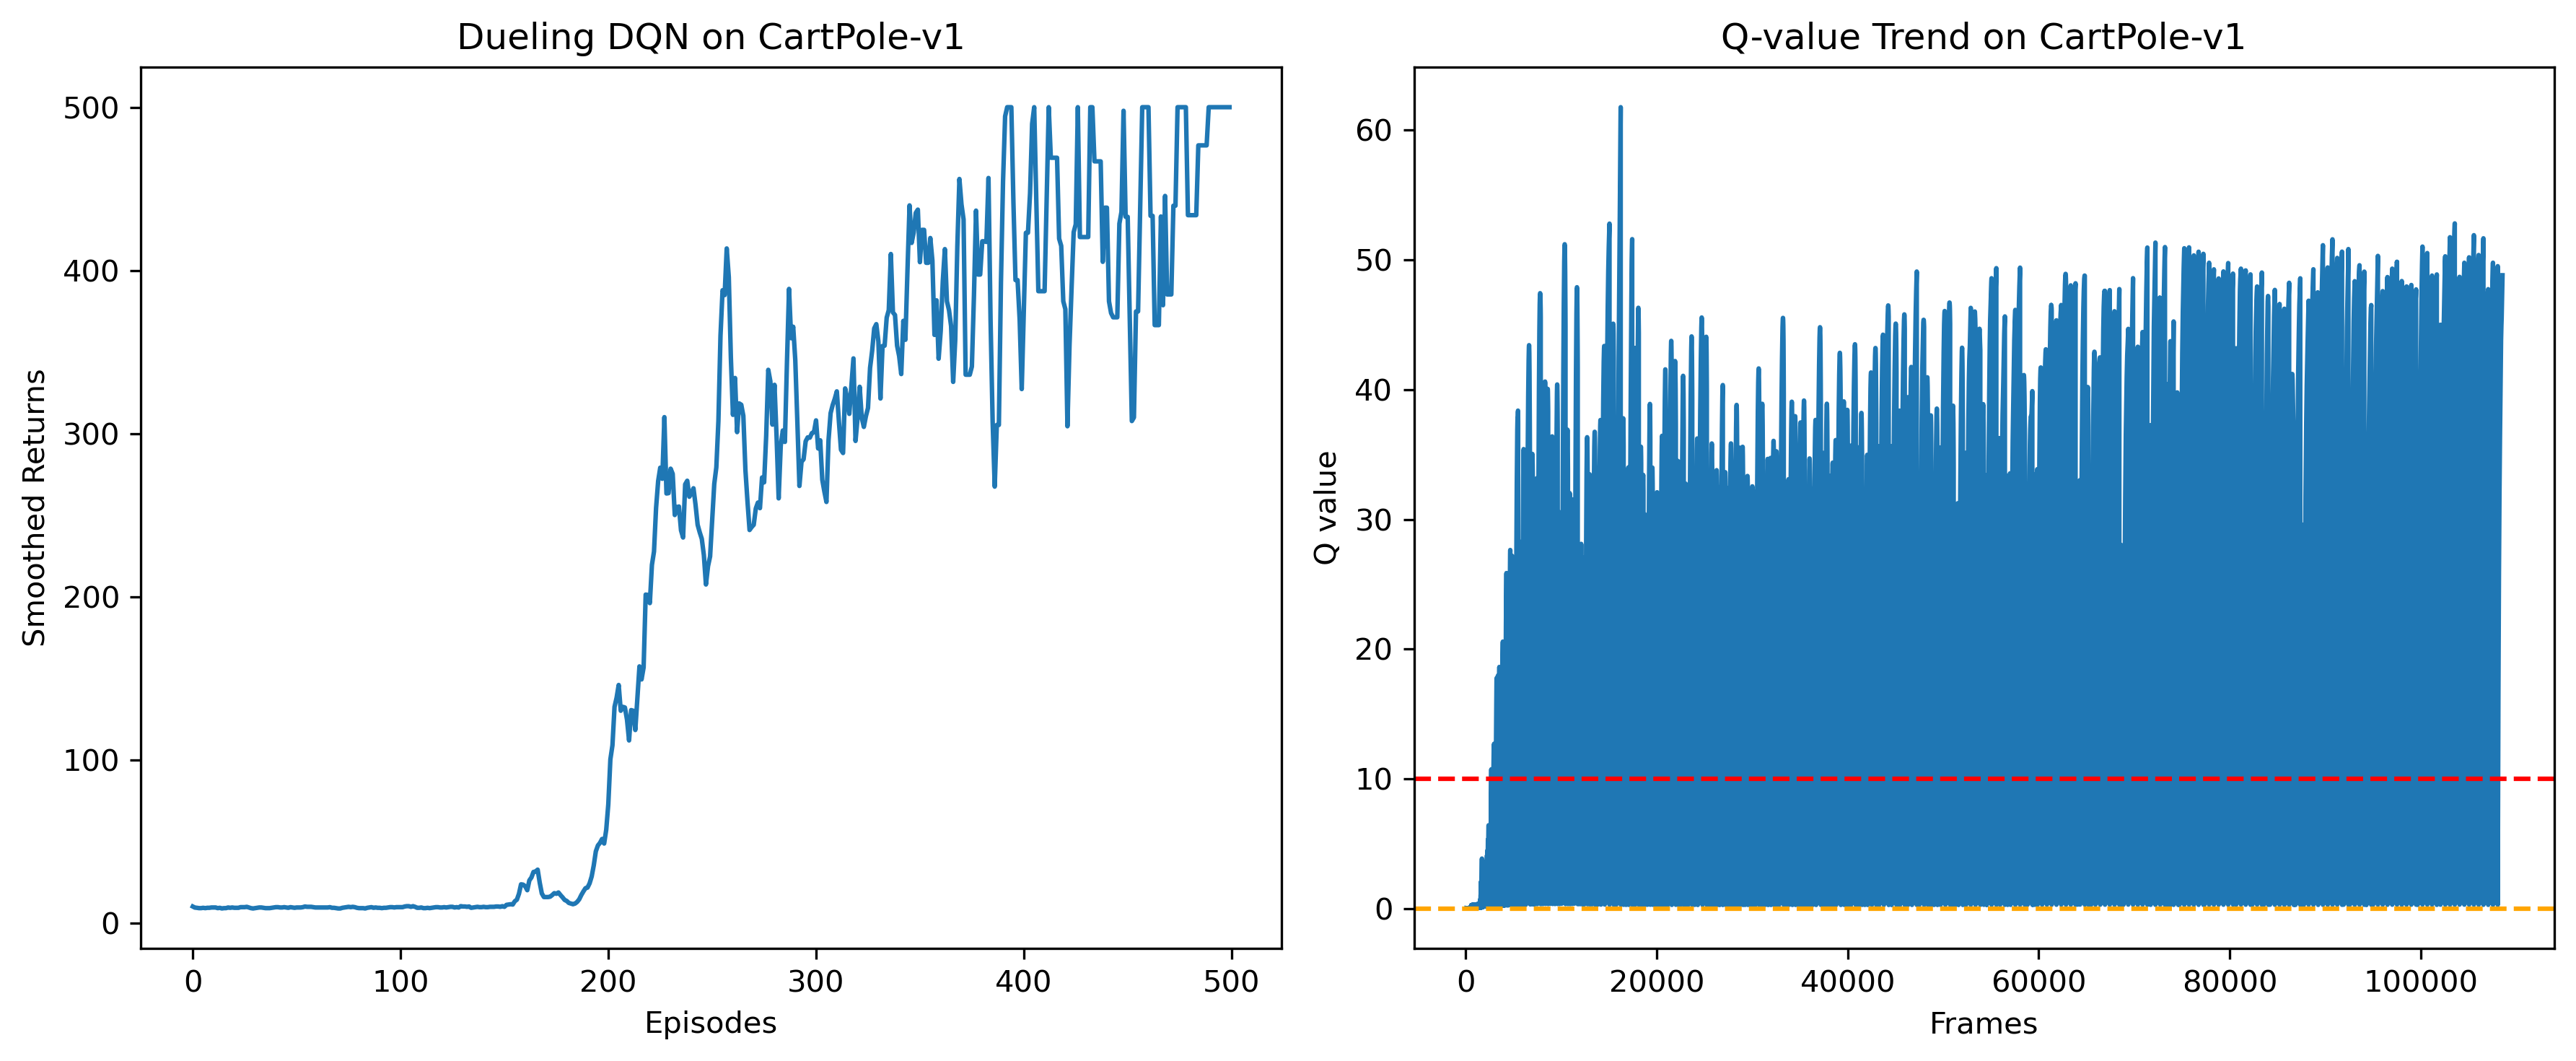

In [18]:
lr = 2e-3
num_episodes = 500
hidden_dim = 128
gamma = 0.98
epsilon = 0.01
target_update = 10
buffer_size = 10000
minimal_size = 500
batch_size = 64
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    
env_name = 'CartPole-v1'
env = gym.make(env_name)

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

# 实例化
replay_buffer = ReplayBuffer(buffer_size)
agent = DuelingDQN(state_dim, hidden_dim, action_dim, lr, gamma, epsilon,
            target_update, device)

return_list, max_q_value_list = train_DQN(agent, env, num_episodes,
                                          replay_buffer, minimal_size,
                                          batch_size)
env.close()

episodes_list = list(range(len(return_list)))
mv_return = moving_average(return_list, 5)
    
plt.figure(figsize=(12, 5), dpi = 300)
    
plt.subplot(1, 2, 1)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Smoothed Returns')
plt.title(f'Dueling DQN on {env_name}')

plt.subplot(1, 2, 2)
frames_list = list(range(len(max_q_value_list)))
plt.plot(frames_list, max_q_value_list)
plt.axhline(0, c='orange', ls='--')
plt.axhline(10, c='red', ls='--')
plt.xlabel('Frames')
plt.ylabel('Q value')
plt.title(f'Q-value Trend on {env_name}')
    
plt.tight_layout()
plt.show()

### 4.2.3 Double Dueling DQN
将Double DQN和Dueling DQN相结合。

In [19]:
class VAnet(nn.Module):
    ''' Dueling DQN 网络结构 '''
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(VAnet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)  # 共享网络部分
        self.fc_A = torch.nn.Linear(hidden_dim, action_dim) # 优势函数 A
        self.fc_V = torch.nn.Linear(hidden_dim, 1)          # 状态价值函数 V

    def forward(self, x):
        # 分别计算 A 和 V 
        x_relu = F.relu(self.fc1(x))
        A = self.fc_A(x_relu)
        V = self.fc_V(x_relu)
        # 聚合得到 Q 值
        Q = V + A - A.mean(1).view(-1, 1)
        return Q

class DoubleDuelingDQN:
    ''' Double Dueling DQN '''
    def __init__(self, state_dim, hidden_dim, action_dim, learning_rate, gamma,
                 epsilon, target_update, device):
        self.action_dim = action_dim
        self.q_net = VAnet(state_dim, hidden_dim, self.action_dim).to(device)   # 这里采用Dueling DQN的网络结构
        self.target_q_net = VAnet(state_dim, hidden_dim, self.action_dim).to(device)    # Dueling DQN

        self.optimizer = torch.optim.Adam(self.q_net.parameters(), lr=learning_rate)
        self.gamma = gamma
        self.epsilon = epsilon
        self.target_update = target_update
        self.count = 0
        self.device = device

    def take_action(self, state):
        if np.random.random() < self.epsilon:
            action = np.random.randint(self.action_dim)
        else:
            state = torch.tensor([state], dtype=torch.float).to(self.device)
            action = self.q_net(state).argmax().item()
        return action

    def max_q_value(self, state):
        with torch.no_grad():
            state = torch.tensor([state], dtype=torch.float).to(self.device)
            return self.q_net(state).max().item()

    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'], dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions']).view(-1, 1).to(self.device)
        rewards = torch.tensor(transition_dict['rewards'], dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'], dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'], dtype=torch.float).view(-1, 1).to(self.device)

        q_values = self.q_net(states).gather(1, actions)
        
        # 这里采用Double DQN的目标值计算方式
        max_action = self.q_net(next_states).max(1)[1].view(-1, 1)
        max_next_q_values = self.target_q_net(next_states).gather(1, max_action)

        q_targets = rewards + self.gamma * max_next_q_values * (1 - dones)
        dqn_loss = torch.mean(F.mse_loss(q_values, q_targets))
        self.optimizer.zero_grad()
        dqn_loss.backward()
        self.optimizer.step()

        if self.count % self.target_update == 0:
            self.target_q_net.load_state_dict(self.q_net.state_dict())
        self.count += 1

def train_DQN(agent, env, num_episodes, replay_buffer, minimal_size, batch_size):
    return_list = []
    max_q_value_list = []
    
    with tqdm(total=num_episodes, desc="Training") as pbar:
        for i_episode in range(num_episodes):
            episode_return = 0
            
            state, info = env.reset()
            
            max_q_value = 0
            done = False
            while not done:
                action = agent.take_action(state)
                
                max_q_value = agent.max_q_value(state) * 0.005 + max_q_value * 0.995
                max_q_value_list.append(max_q_value)

                next_state, reward, terminated, truncated, info = env.step(action)
                done = terminated or truncated

                replay_buffer.add(state, action, reward, next_state, done)
                state = next_state
                episode_return += reward

                if replay_buffer.size() > minimal_size:
                    b_s, b_a, b_r, b_ns, b_d = replay_buffer.sample(batch_size)
                    transition_dict = {'states': b_s, 'actions': b_a, 'rewards': b_r, 'next_states': b_ns, 'dones': b_d}
                    agent.update(transition_dict)

            return_list.append(episode_return)
            pbar.set_postfix({'return': '%.3f' % episode_return})
            pbar.update(1)
            
    return return_list, max_q_value_list

Training: 100%|██████████| 500/500 [00:20<00:00, 24.65it/s, return=257.000]


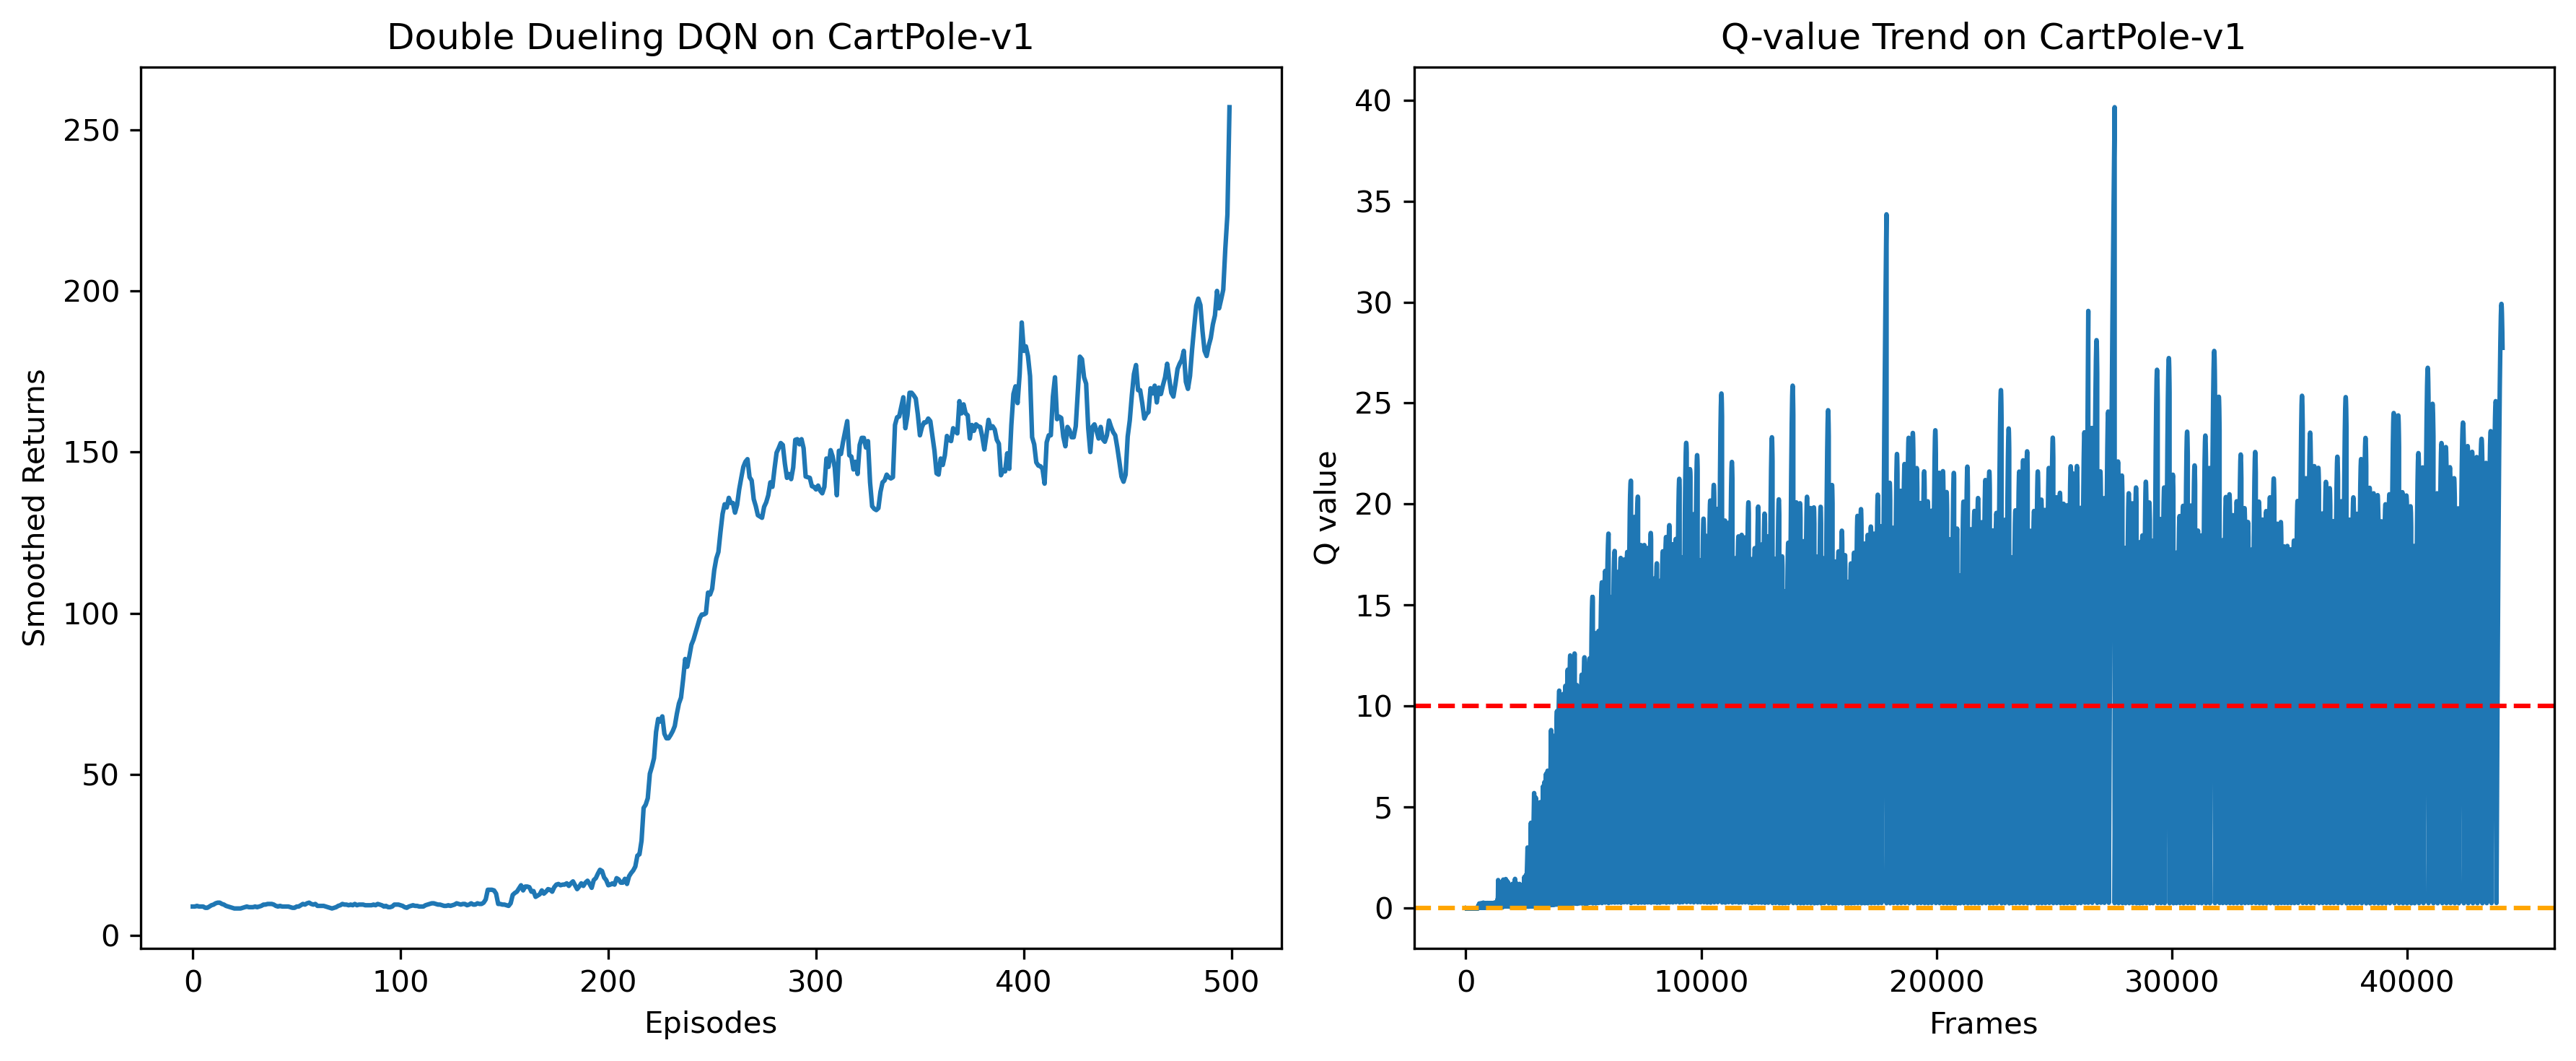

In [23]:
lr = 2e-3
num_episodes = 500
hidden_dim = 128
gamma = 0.98
epsilon = 0.01
target_update = 10
buffer_size = 10000
minimal_size = 500
batch_size = 64
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    
env_name = 'CartPole-v1'
env = gym.make(env_name)

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
env.reset(seed=0)

state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

# 实例化
replay_buffer = ReplayBuffer(buffer_size)
agent = DuelingDQN(state_dim, hidden_dim, action_dim, lr, gamma, epsilon,
            target_update, device)

return_list, max_q_value_list = train_DQN(agent, env, num_episodes,
                                          replay_buffer, minimal_size,
                                          batch_size)
env.close()

episodes_list = list(range(len(return_list)))
mv_return = moving_average(return_list, 5)
    
plt.figure(figsize=(12, 5), dpi = 300)
    
plt.subplot(1, 2, 1)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Smoothed Returns')
plt.title(f'Double Dueling DQN on {env_name}')

plt.subplot(1, 2, 2)
frames_list = list(range(len(max_q_value_list)))
plt.plot(frames_list, max_q_value_list)
plt.axhline(0, c='orange', ls='--')
plt.axhline(10, c='red', ls='--')
plt.xlabel('Frames')
plt.ylabel('Q value')
plt.title(f'Q-value Trend on {env_name}')
    
plt.tight_layout()
plt.show()

可以看出Double DQN和Dueling DQN的训练稳定性相较于基础DQN而言均有所提升，而将两个提升版的DQN再次结合之后，Double Dueling DQN的训练稳定性又有了进一步提升，体现出两个关键改进的效果。